In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imshow, imread
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import cv2
from sklearn import ensemble
from PIL import Image
import seaborn as sn
import pandas as pd

# Creating dataset

In [2]:
images_path = "F:\Projects\MEDH_projects\ExtractingImageFeaturesHSV\EuroSAT\\2750"

In [3]:
labels_name = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industial", "Pasture", "PermanentCrop",
          "Residential", "River", "SeaLake"]

In [4]:
images = []
labels = []

In [5]:
for folder in os.listdir(images_path):
    folder_path = images_path + f"\\{folder}"
    for image in os.listdir(folder_path):
        images.append(imread(f"{images_path}\\{folder}\\{image}"))
        labels.append(folder)

F:\Projects\MEDH_projects\ExtractingImageFeaturesHSV\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


'Forest'

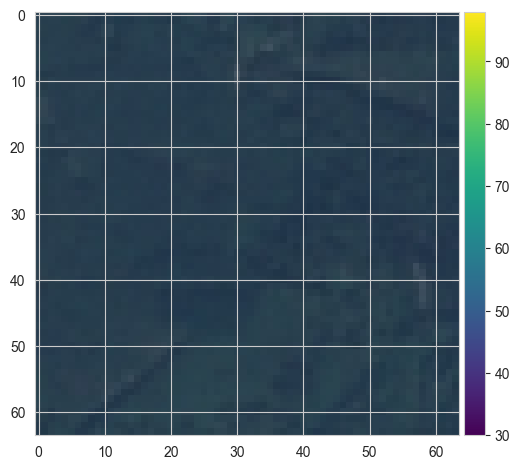

In [6]:
imshow(images[3000])
labels[3000]

# Feature extraction

In [7]:
def hue_histogram(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, _, _ = cv2.split(hsv)
    hist = cv2.calcHist([hue], [0], None, [180], [0, 180])
    hist = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)

    return hist.ravel()

In [10]:
def hsv_histogram(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue, sat, value = cv2.split(hsv)

    hue_hist = cv2.calcHist([hue], [0], None, [180], [0, 180])
    hue_hist = cv2.normalize(hue_hist, hue_hist, 0, 1, cv2.NORM_MINMAX)

    sat_hist = cv2.calcHist([sat], [0], None, [256], [0, 256])
    sat_hist = cv2.normalize(sat_hist, sat_hist, 0, 1, cv2.NORM_MINMAX)

    value_hist = cv2.calcHist([value], [0], None, [256], [0, 256])
    value_hist = cv2.normalize(value_hist, value_hist, 0, 1, cv2.NORM_MINMAX)
    return np.concatenate((hue_hist.ravel(), sat_hist.ravel(), value_hist.ravel()))

In [8]:
images_hue = []
for image in images:
    images_hue.append(hue_histogram(image))

In [9]:
images_hue[0].shape

(180,)

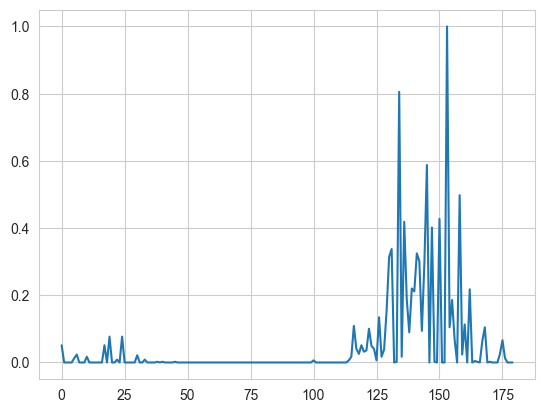

In [10]:
plt.plot(images_hue[0])

# Dimensionality Reduction

## LDA

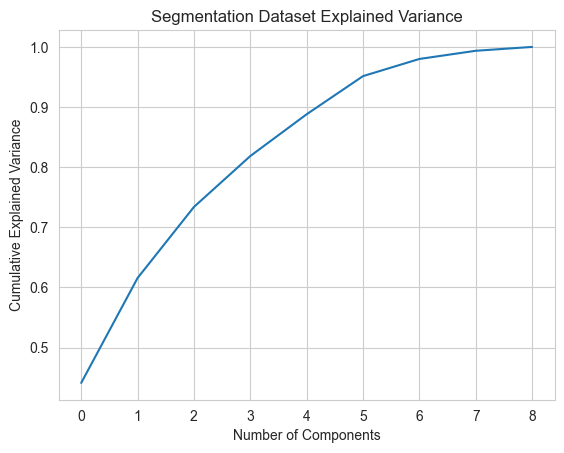

In [11]:
# Fitting the PCA algorithm with our Data
pca = LDA()
pca.fit(images_hue, labels)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Segmentation Dataset Explained Variance')
plt.show(block=True)

In [11]:
lda = LDA(n_components=9)
images_hue_reduced = lda.fit_transform(images_hue, labels)

## PCA

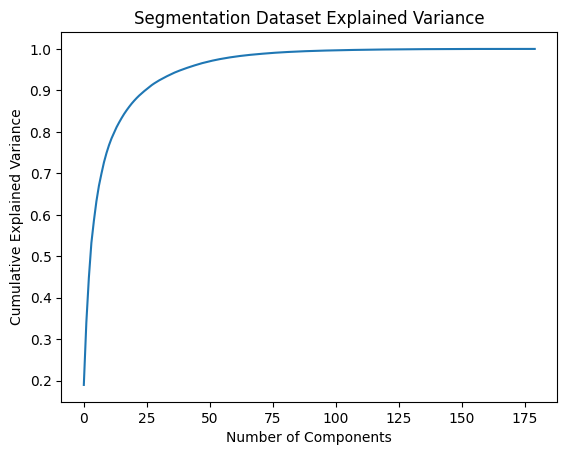

In [264]:
pca = PCA()
pca.fit(images_hue)
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  # for each component
plt.title('Segmentation Dataset Explained Variance')
plt.show(block=True)

In [265]:
pca = PCA(n_components=75)
images_hue_reduced = pca.fit_transform(images_hue, labels)

# Creating train and test datasets

In [12]:
train_ds, test_ds, train_tags, test_tags = train_test_split(images_hue_reduced, labels, test_size=0.2, shuffle=True)

In [15]:
train_ds, test_ds, train_tags, test_tags = train_test_split(images_hue, labels, test_size=0.2, shuffle=True)

# Trainging the model and test

In [13]:
model = ensemble.RandomForestClassifier(n_estimators=100)
model.fit(train_ds, train_tags)

RandomForestClassifier()

In [14]:
predicts = model.predict(test_ds)

accuracy = accuracy_score(y_true=test_tags, y_pred = predicts)
print("Accuracy = ", accuracy)

Accuracy =  0.6844444444444444


<Figure size 15000x15000 with 0 Axes>

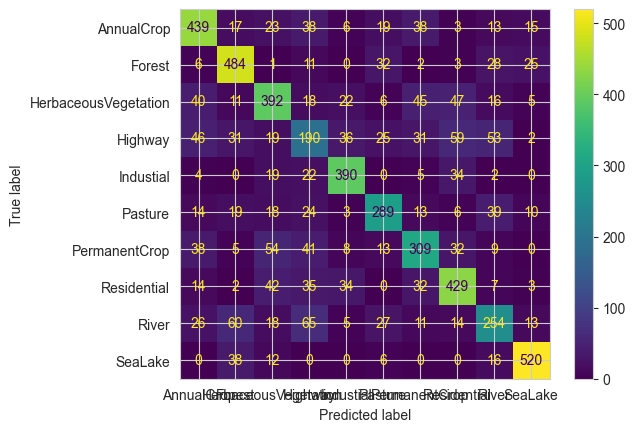

In [17]:
confusion_matrix_result = confusion_matrix(y_true=test_tags, y_pred = predicts)
plt.figure(figsize=(100, 100), dpi=150)
cm_display = ConfusionMatrixDisplay(confusion_matrix_result, display_labels = labels_name)
cm_display.plot()
plt.show()

In [22]:
confusion_matrix = confusion_matrix_result.astype('float') / confusion_matrix_result.sum(axis=1)[:, np.newaxis]
#The diagonal entries are the accuracies of each class
confusion_matrix.diagonal()

array([0.71849427, 0.81756757, 0.65116279, 0.38617886, 0.81932773,
       0.66436782, 0.60707269, 0.7173913 , 0.51521298, 0.87837838])

# Trainning loops

### Estimators

In [89]:
accuracy_tests = []
for estimators in range(20, 201, 20):
    model = ensemble.RandomForestClassifier(n_estimators=estimators)
    model.fit(train_ds, train_tags)

    predicts = model.predict(test_ds)
    accuracy = accuracy_score(y_true=test_tags, y_pred = predicts)
    accuracy_tests.append(accuracy)
    print("Accuracy = ", accuracy)

Accuracy =  0.7442592592592593
Accuracy =  0.76
Accuracy =  0.7611111111111111
Accuracy =  0.7688888888888888
Accuracy =  0.7677777777777778
Accuracy =  0.7727777777777778
Accuracy =  0.769074074074074
Accuracy =  0.7674074074074074
Accuracy =  0.7687037037037037
Accuracy =  0.77


Text(0, 0.5, 'Accuracy')

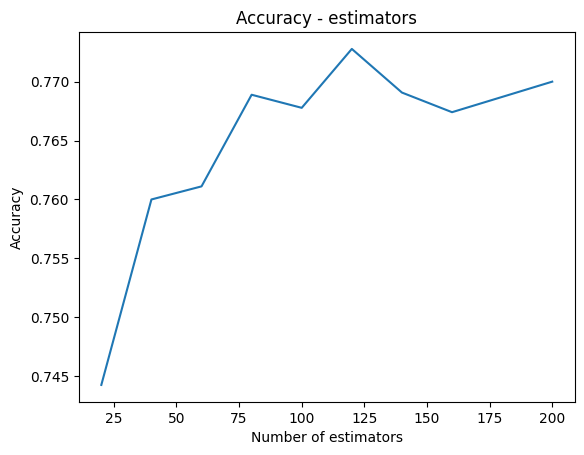

In [90]:
plt.plot(range(20,201,20), accuracy_tests)
plt.title("Accuracy - estimators")
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

### LDA

In [91]:
accuracy_tests = []
for components in range(1, 10):
    lda = LDA(n_components=components)
    images_hue_reduced = lda.fit_transform(images_hue, labels)
    train_ds, test_ds, train_tags, test_tags = train_test_split(images_hue_reduced, labels, test_size=0.2, shuffle=True)
    print("Features: ", len(train_ds[0]))

    model = ensemble.RandomForestClassifier(n_estimators=100)
    model.fit(train_ds, train_tags)

    predicts = model.predict(test_ds)
    accuracy = accuracy_score(y_true=test_tags, y_pred = predicts)
    accuracy_tests.append(accuracy)
    print("Accuracy = ", accuracy)

Features:  1
Accuracy =  0.25537037037037036
Features:  2
Accuracy =  0.4274074074074074
Features:  3
Accuracy =  0.5492592592592592
Features:  4
Accuracy =  0.5927777777777777
Features:  5
Accuracy =  0.6318518518518519
Features:  6
Accuracy =  0.6472222222222223
Features:  7
Accuracy =  0.6557407407407407
Features:  8
Accuracy =  0.665
Features:  9
Accuracy =  0.6837037037037037


Text(0, 0.5, 'Accuracy')

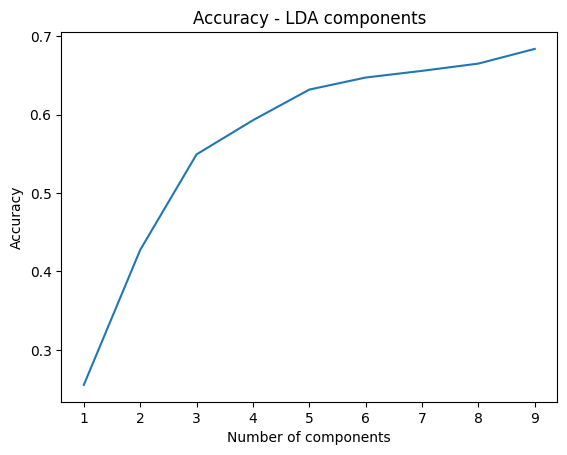

In [92]:
plt.plot(range(1, 10), accuracy_tests)
plt.title("Accuracy - LDA components")
plt.xlabel("Number of components")
plt.ylabel("Accuracy")

### PCA

In [93]:
accuracy_tests = []
for components in range(10, 100, 5):
    pca = PCA(n_components=components)
    images_hue_reduced = pca.fit_transform(images_hue, labels)
    train_ds, test_ds, train_tags, test_tags = train_test_split(images_hue_reduced, labels, test_size=0.2, shuffle=True)
    print("Component: ", components)
    print("Features: ", len(train_ds[0]))

    model = ensemble.RandomForestClassifier(n_estimators=100)
    model.fit(train_ds, train_tags)

    predicts = model.predict(test_ds)
    accuracy = accuracy_score(y_true=test_tags, y_pred = predicts)
    accuracy_tests.append(accuracy)
    print("Accuracy = ", accuracy)

Component:  10
Features:  10
Accuracy =  0.6559259259259259
Component:  15
Features:  15
Accuracy =  0.6946296296296296
Component:  20
Features:  20
Accuracy =  0.7148148148148148
Component:  25
Features:  25
Accuracy =  0.7216666666666667
Component:  30
Features:  30
Accuracy =  0.727037037037037
Component:  35
Features:  35
Accuracy =  0.7374074074074074
Component:  40
Features:  40
Accuracy =  0.7318518518518519
Component:  45
Features:  45
Accuracy =  0.7379629629629629
Component:  50
Features:  50
Accuracy =  0.7483333333333333
Component:  55
Features:  55
Accuracy =  0.7498148148148148
Component:  60
Features:  60
Accuracy =  0.7366666666666667
Component:  65
Features:  65
Accuracy =  0.7355555555555555
Component:  70
Features:  70
Accuracy =  0.7379629629629629
Component:  75
Features:  75
Accuracy =  0.7342592592592593
Component:  80
Features:  80
Accuracy =  0.7346296296296296
Component:  85
Features:  85
Accuracy =  0.7368518518518519
Component:  90
Features:  90
Accuracy =  

Text(0, 0.5, 'Accuracy')

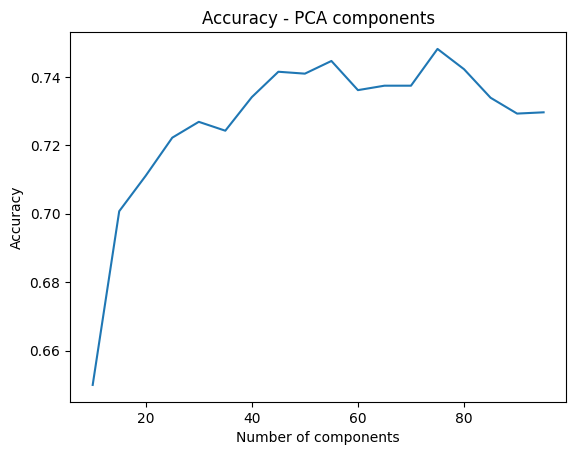

In [75]:
plt.plot(range(10, 100, 5), accuracy_tests)
plt.title("Accuracy - PCA components")
plt.xlabel("Number of components")
plt.ylabel("Accuracy")